Time Series Analysis

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

Data loading

In [277]:
# Load Data
df = pd.read_csv("AirPassengers.csv", parse_dates=["Month"], index_col="Month")


df = df.sort_index()
df = df.fillna(method='ffill')  # Forward fill missing values

C:\Users\anton\AppData\Local\Temp\ipykernel_16884\4059467261.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Forward fill missing values


In [278]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


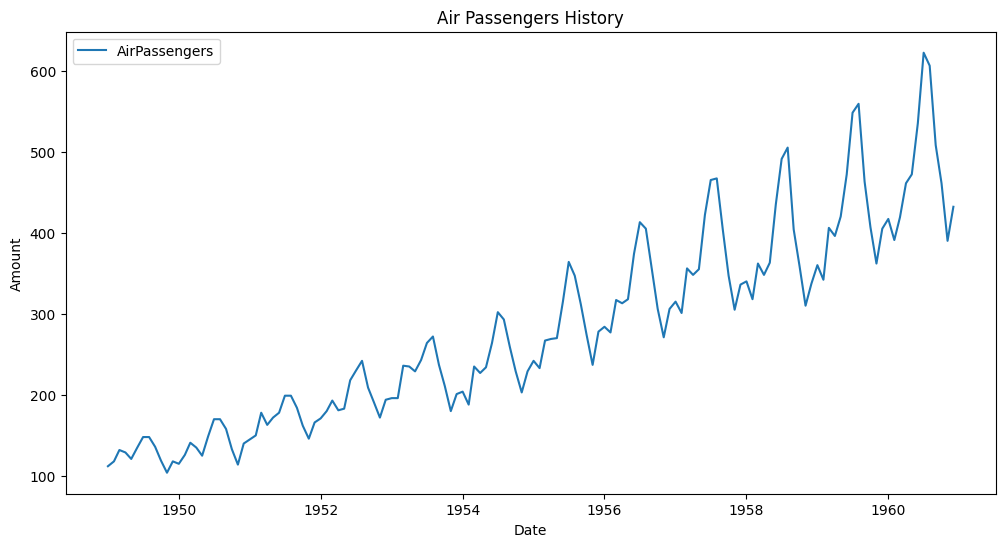

In [279]:
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='AirPassengers')
plt.title('Air Passengers History')
plt.xlabel('Date')
plt.ylabel('Amount')
plt.legend()
plt.show()


Stationarity check

In [280]:
result = adfuller(df['Passengers'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] > 0.05:
    print("Time series is not stationary")
    df['Passengers_diff'] = df['Passengers'].diff().dropna()
else:
    print("Time series is stationary.")

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641
Time series is not stationary


In [281]:
result = adfuller(df['Passengers_diff'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.8292668241699994
p-value: 0.0542132902838255


Secont differetiation

In [282]:
df['Passengers_diff'] = df['Passengers_diff'].diff().dropna()

In [283]:
result = adfuller(df['Passengers_diff'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -16.384231542468505
p-value: 2.7328918500142407e-29


Time series decomposition

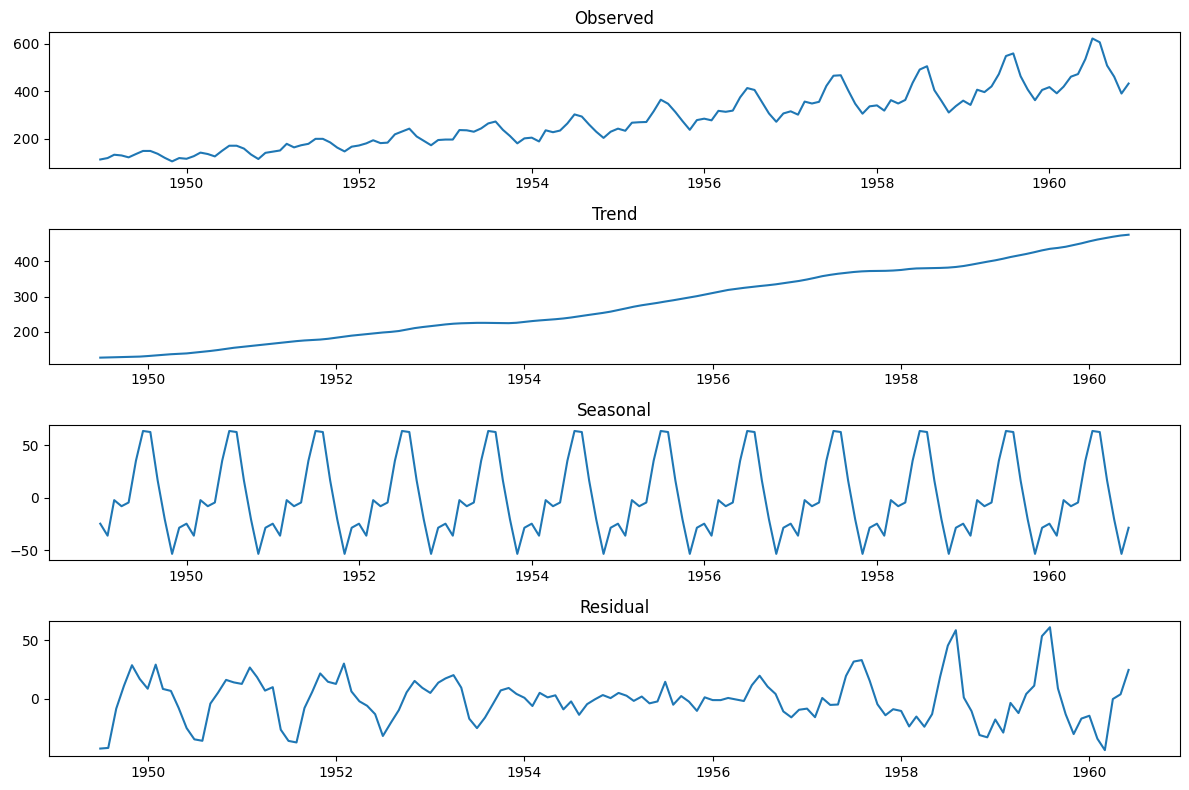

In [284]:
decomposition = seasonal_decompose(df['Passengers'], model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

Autocorrelation Analysis

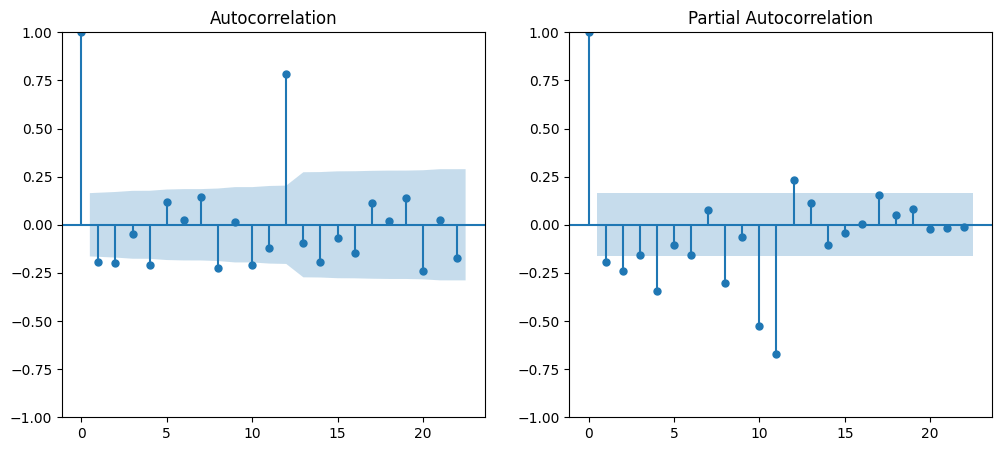

In [285]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Passengers_diff'].dropna(), ax=ax[0])
plot_pacf(df['Passengers_diff'].dropna(), ax=ax[1])
plt.show()

ARIMA 

In [286]:
train_size = int(len(df) * 0.8)
train = df['Passengers'][:train_size]
test= df['Passengers'][train_size:]

In [287]:
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False, suppress_warnings=True)
auto_arima

C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [288]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -525.417
Date:                Sun, 16 Feb 2025   AIC                           1058.834
Time:                        14:54:51   BIC                           1069.778
Sample:                    01-01-1949   HQIC                          1063.276
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.1853      4.424      1.172      0.241      -3.486      13.856
ar.L1         -0.5209      0.112     -4.640      0.000      -0.741      -0.301
ma.L1          0.9178      0.056     16.361      0.000       0.808       1.028
sigma2       585.4553    100.197      5.843      0.000     389.073     781.838
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.71   Prob(JB):                         0.33
Heteroskedasticity (H):               5.22   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [289]:
model = ARIMA(train, order=(12,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:                ARIMA(12, 1, 1)   Log Likelihood                -424.153
Date:                Sun, 16 Feb 2025   AIC                            876.306
Time:                        14:54:52   BIC                            914.613
Sample:                    01-01-1949   HQIC                           891.853
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0904      0.088      1.023      0.307      -0.083       0.264
ar.L2         -0.0931      0.067     -1.382      0.167      -0.225       0.039
ar.L3          0.0494      0.057      0.865      0.3

C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


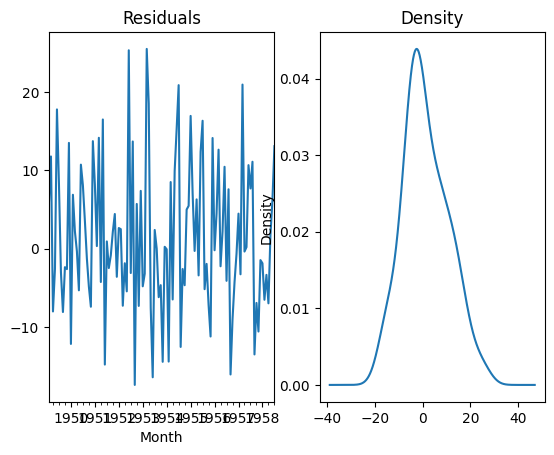

In [290]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [291]:
forecast = model_fit.forecast(len(test))
conf_int = model_fit.get_forecast(steps=len(test)).conf_int()

In [292]:
# Model Evaluation
mae = mean_absolute_error(test, forecast)
rmse = math.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

MAE: 38.200924028253276
RMSE: 47.37444395354183
R² Score: 0.6323463582949764


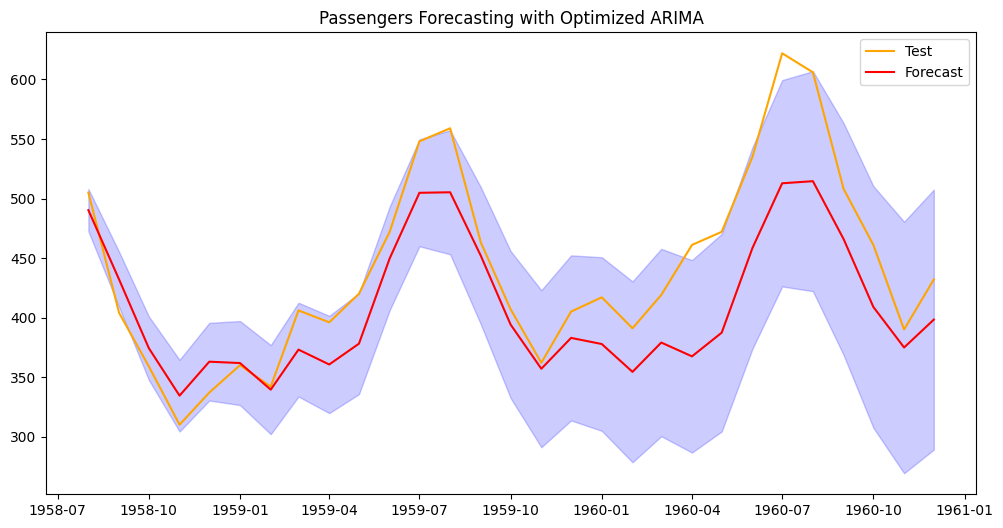

In [293]:
plt.figure(figsize=(12, 6))
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Passengers Forecasting with Optimized ARIMA')
plt.legend()
plt.show()

SARIMA

In [294]:
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=True, suppress_warnings=True, m=1)
auto_arima

C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' wa

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

In [295]:
model = ARIMA(train, order=(1,1,1), seasonal_order=(1, 1, 1, 12)) #monthly seasonality
model_fit = model.fit()
print(model_fit.summary())

C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anton\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:                       Passengers   No. Observations:                  115
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -374.130
Date:                          Sun, 16 Feb 2025   AIC                            758.260
Time:                                  14:54:56   BIC                            771.385
Sample:                              01-01-1949   HQIC                           763.575
                                   - 07-01-1958                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6366      0.334     -1.908      0.056      -1.290       0.017
ma.L1          0.4605      0.372      1.237      0.

In [296]:
forecast = model_fit.forecast(len(test))
conf_int = model_fit.get_forecast(steps=len(test)).conf_int()

In [297]:
# Model Evaluation
mae = mean_absolute_error(test, forecast)
rmse = math.sqrt(mean_squared_error(test, forecast))
r2 = r2_score(test, forecast)
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

MAE: 23.55558106170159
RMSE: 30.141853376371404
R² Score: 0.8511699845704088


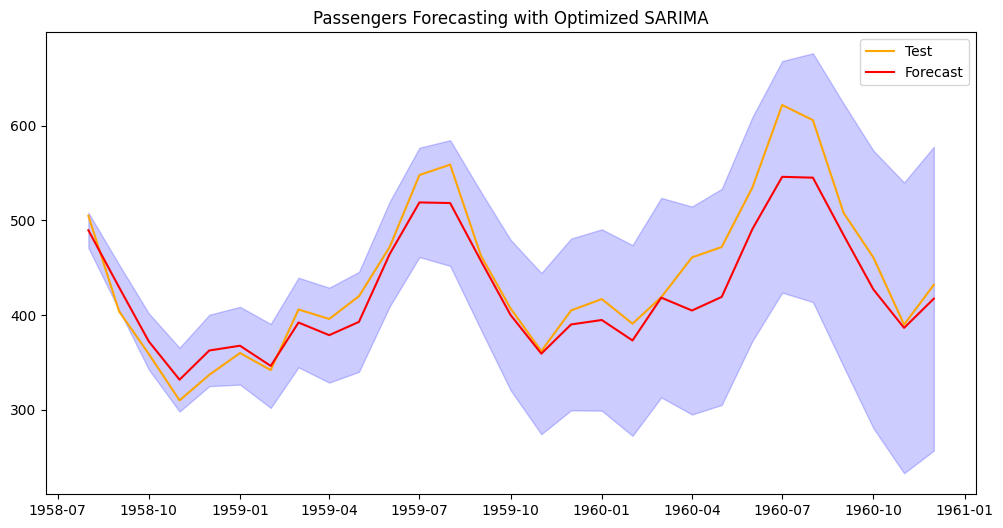

In [298]:
plt.figure(figsize=(12, 6))
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='blue', alpha=0.2)
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Passengers Forecasting with Optimized SARIMA')
plt.legend()
plt.show()